# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 4
# Regularization, High Dimensionality, PCA


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): AC209

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
import seaborn as sns
%matplotlib inline

D:\Anaconda3\envs\py36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Continuing Bike Sharing Usage Data

In this homework, we will focus on multiple linear regression, regularization, dealing with high dimensionality, and PCA. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See Homework 3 for more information about the data.

*Note: please make sure you use all the processed data from HW 3 Part (a)...you make want to save the data set on your computer and reread the csv/json file here.


In [3]:
dtype_dict = {"season":int, "month":int, "holiday":int, "day_of_week": int, "workingday":int, "weather":int, \
             "temp":float, "atemp":float, "humidity":float, "windspeed": float, "count":int}

In [4]:
# Load data from HW3
bike_train_df = pd.read_csv('data/bike_train.csv', index_col=0, low_memory=False)
bike_test_df = pd.read_csv('data/bike_test.csv', index_col=0, low_memory=False)
bike_train_df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,season_3,...,month_11,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_1,weather_2,weather_3
0,0,1,0.624743,0.651090,0.922058,-0.930164,6073,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,0,1,-0.180583,-0.054841,0.697907,-0.213825,6606,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,1,0.803704,0.852785,-0.449062,0.805143,7363,0,1,0,...,0,0,0,0,1,0,0,1,0,0
3,0,0,-1.522794,-1.567551,-0.332616,-0.269507,2431,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0.535262,0.348548,1.978781,-1.200843,1996,0,0,1,...,0,0,0,1,0,0,0,0,0,1


## Part (f): Regularization/Penalization Methods

As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

Use the following regularization techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression
    
You may choose the shrikage parameter $\lambda$ from the set $\{10^{-5}, 10^{-4},...,10^{4},10^{5}\}$ using cross-validation. In each case, 

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?
- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

We next analyze the performance of the two shrinkage methods for different training sample sizes:
- Generate random samples of sizes 100, 150, ..., 400 from the training set. You may use the following code to draw a random sample of a specified size from the training set:

In [5]:
X_train = bike_train_df.drop('count', axis=1).copy()
Y_train = bike_train_df['count']

X_test = bike_test_df.drop('count', axis=1).copy()
Y_test = bike_test_df['count']

In [6]:
MLR_result = OLS(Y_train, sm.add_constant(X_train)).fit()
coef_ind = MLR_result.params.index.tolist()

In [7]:
shrikage = 10.**np.arange(-5, 6)

In [8]:
coef_dict = dict()
for s in shrikage:
    
    ridge_cv_model = RidgeCV(alphas=[s])
    ridge_cv_result = ridge_cv_model.fit(X_train, Y_train)
    ridge_params = np.hstack((ridge_cv_result.intercept_, ridge_cv_result.coef_))
    ridge_series = pd.Series(data=ridge_params, index=coef_ind)
    
    lasso_cv_model = LassoCV(alphas=[s], max_iter=1e5)
    lasso_cv_result = lasso_cv_model.fit(X_train, Y_train)
    lasso_params = np.hstack((lasso_cv_result.intercept_, lasso_cv_result.coef_))
    lasso_series = pd.Series(data=lasso_params, index=coef_ind)
    
    all_params_df = pd.concat({'All':MLR_result.params, 'Ridge':ridge_series, 'Lasso':lasso_series}, axis=1)
    coef_dict[str(s)] = all_params_df

D:\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [9]:
coef_dict.keys()

dict_keys(['1e-05', '0.0001', '0.001', '0.01', '0.1', '1.0', '10.0', '100.0', '1000.0', '10000.0', '100000.0'])

In [10]:
coef_dict['1.0']

,All,Lasso,Ridge
const,3192.209225,4747.892483,4204.708320
holiday,-284.356275,-185.908268,-244.125575
workingday,308.153142,367.097850,296.816742
temp,924.334403,892.793640,809.380072
atemp,311.961760,320.899770,381.424635
humidity,-547.663783,-545.623270,-544.331033
windspeed,-254.736916,-252.605100,-253.325313
season_1,-1226.186543,-1117.607718,-1059.725202
season_2,-327.357503,-231.522796,-228.539407
season_3,-193.304968,-166.721222,-221.729595


In [11]:
for s in shrikage:
    zero_coef = coef_dict[str(s)]['Lasso'].index[np.abs(coef_dict[str(s)]['Lasso']) < 1e-10].tolist()
    print("With alpah = %s: The coefficients of the following predictors goes to 0:\n\t%s\n" % (s, zero_coef))

With alpah = 1e-05: The coefficients of the following predictors goes to 0:
	['day_of_week_4']

With alpah = 0.0001: The coefficients of the following predictors goes to 0:
	['day_of_week_4']

With alpah = 0.001: The coefficients of the following predictors goes to 0:
	['day_of_week_4']

With alpah = 0.01: The coefficients of the following predictors goes to 0:
	['day_of_week_4']

With alpah = 0.1: The coefficients of the following predictors goes to 0:
	['day_of_week_4', 'weather_2']

With alpah = 1.0: The coefficients of the following predictors goes to 0:
	['month_1', 'month_5', 'day_of_week_4', 'weather_2']

With alpah = 10.0: The coefficients of the following predictors goes to 0:
	['holiday', 'season_2', 'month_2', 'month_5', 'day_of_week_4', 'weather_2']

With alpah = 100.0: The coefficients of the following predictors goes to 0:
	['holiday', 'workingday', 'season_2', 'season_3', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', '

For shrikage = 1e-5 to 1e-1
> Both Lasso and Ridge give very similar coefficients compared to the plain linear regression method without penalty, except for some terms. The main difference is in the intercept, holiday, day_of_week_3 and 4 and the weathers. In particular, most of Ridge's coefficients are almost identical. This makes sense since alpha, which can be thought of as the "amplification" of the penalizing term, is small. Thus not much penalty is added.

For shrikage = 1 to 1e5 
> Both Lasso and Ridge diverge from the original model. As the shrikage parameter alpha keey increasing, more coefficients in the LASSO regularization model go to zero. At the extreme case alpha = 1e5, all coefficients go to 0 as the penalty term dominate the linear regression term. However, the coefficients in Ridge model never go to 0 but shrink together

At shrikage = 10, only the coefficients for "temp", "atemp", "humidity", "windspeed" and "season_1" has non-zero coefficients, which are included in the Forward and Backward selection (redundancy removal) performed in HW3

For smaller shrikage alpha (< 1), the coefficients for "temp" and "atemp" predicted from Lasso and Ridge are similar to each other and to the original method. For large alpha, Lasso and Ridge predictions give a decreasing coefficients for "temp" and an increasing one for "atemp", where Lasso has a more drastic change.

In [12]:
#--------  sample
# A function to select a random sample of size k from the training set
# Input: 
#      x (n x d Dataframe)
#      y (n x 1 Dataframe)
#      k (size of sample) 
# Return: 
#      chosen sample of predictors and responses

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x.loc[subset_ind, :]
    y_subset = y.loc[subset_ind]
    
    return (x_subset, y_subset)

- Fit linear, Ridge and Lasso regression models to each of the generated sample. In each case, compute the $R^2$ score for the model on the training sample on which it was fitted, and on the test set.
- Repeat the above experiment for 10 random trials/splits, and compute the average train and test $R^2$ across the trials for each training sample size. Also, compute the standard deviation (SD) in each case.
- Make a plot of the mean training $R^2$ scores for the linear, Ridge and Lasso regression methods as a function of the training sample size. Also, show a confidence interval for the mean scores extending from **mean - SD** to **mean + SD**. Make a similar plot for the test $R^2$ scores.

How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated $R^2$ change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values. You may use the `plt.errorbar` function to plot confidence bars for the average $R^2$ scores.

In [13]:
sample_sizes = np.arange(100, 400, 50)
sample_sizes

array([100, 150, 200, 250, 300, 350])

In [14]:
linear_R2_train = []
linear_R2_test = []
ridge_R2_train = []
ridge_R2_test = []
lasso_R2_train = []
lasso_R2_test = []
trials = 10

for s in sample_sizes:
    for i in range(trials):
        X_train_sub, Y_train_sub = sample(X_train, Y_train, s)
        
        MLR_result = OLS(Y_train_sub, X_train_sub).fit()
        linear_R2_train.append(r2_score(Y_train_sub, MLR_result.predict(X_train_sub)))
        linear_R2_test.append(r2_score(Y_test, MLR_result.predict(X_test)))              
        
        ridge_cv_model = RidgeCV(alphas=shrikage)
        ridge_cv_result = ridge_cv_model.fit(X_train_sub, Y_train_sub)
        ridge_R2_train.append(r2_score(Y_train_sub, ridge_cv_result.predict(X_train_sub)))
        ridge_R2_test.append(r2_score(Y_test, ridge_cv_result.predict(X_test)))
        
        lasso_cv_model = LassoCV(alphas=shrikage, max_iter=1e5)
        lasso_cv_result = lasso_cv_model.fit(X_train_sub, Y_train_sub)
        lasso_R2_train.append(r2_score(Y_train_sub, lasso_cv_result.predict(X_train_sub)))
        lasso_R2_test.append(r2_score(Y_test, lasso_cv_result.predict(X_test)))

linear_R2_train = np.array(linear_R2_train).reshape((len(sample_sizes), trials))
linear_R2_test = np.array(linear_R2_test).reshape((len(sample_sizes), trials))
ridge_R2_train = np.array(ridge_R2_train).reshape((len(sample_sizes), trials))
ridge_R2_test = np.array(ridge_R2_test).reshape((len(sample_sizes), trials))
lasso_R2_train = np.array(lasso_R2_train).reshape((len(sample_sizes), trials))
lasso_R2_test = np.array(lasso_R2_test).reshape((len(sample_sizes), trials))

D:\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


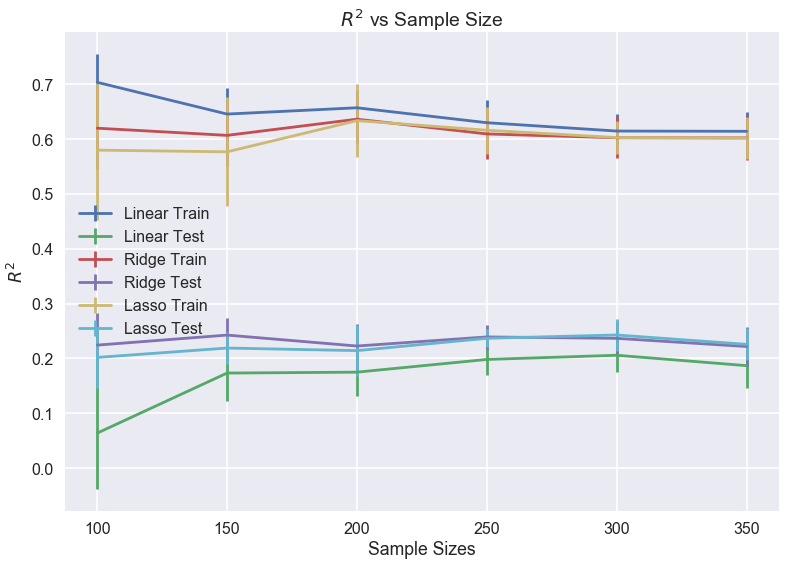

In [15]:
sns.set_context('poster')
plt.errorbar(x=sample_sizes, y=np.mean(linear_R2_train, axis=1), yerr=np.std(linear_R2_train, axis=1), label='Linear Train')
plt.errorbar(x=sample_sizes, y=np.mean(linear_R2_test, axis=1), yerr=np.std(linear_R2_test, axis=1), label='Linear Test')
plt.errorbar(x=sample_sizes, y=np.mean(ridge_R2_train, axis=1), yerr=np.std(ridge_R2_train, axis=1), label='Ridge Train')
plt.errorbar(x=sample_sizes, y=np.mean(ridge_R2_test, axis=1), yerr=np.std(ridge_R2_test, axis=1), label='Ridge Test')
plt.errorbar(x=sample_sizes, y=np.mean(lasso_R2_train, axis=1), yerr=np.std(lasso_R2_train, axis=1), label='Lasso Train')
plt.errorbar(x=sample_sizes, y=np.mean(lasso_R2_test, axis=1), yerr=np.std(lasso_R2_test, axis=1), label='Lasso Test')
plt.legend(loc='best')
plt.title('$R^2$ vs Sample Size')
plt.xlabel('Sample Sizes')
plt.ylabel('$R^2$')
plt.show()

With smaller sample sizes, plain linear regression gives the best $R^2$ score in the training set but the worst in the testing set. This can be explained by over-fitting of the simple linear regression model. Although Ridge model has better training $R^2$ score than Lasso for smaller sample sizes, their performance for testing set are really close to each other, except that Ridge has smaller STD (confidence interval). Hence, for small sample size, I would recommend Ridge model for fitting.

## Part (g): Polynomial & Interaction Terms

Moving beyond linear models, we will now try to improve the performance of the regression model in Part (b) from HW 3 by including higher-order polynomial and interaction terms. 

- For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

- Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

#### Polynomial Terms ####

In [16]:
# Expand the selected column with their polynomials
# X: Dataframe
# col: List of column names
# order: the orders of polynomials

def expand_poly(X, col, order):
    X_temp = X.copy()
    for c in col:
        for o in range(2, order+1):
            X_temp[c+'_'+str(o)] = X_temp[c]**o
    
    return X_temp

In [17]:
X_train_poly = expand_poly(X_train, ['temp', 'atemp', 'humidity', 'windspeed'], 4)

In [18]:
X_train_poly.head()

,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,month_1,...,temp_4,atemp_2,atemp_3,atemp_4,humidity_2,humidity_3,humidity_4,windspeed_2,windspeed_3,windspeed_4
0,0,1,0.624743,0.651090,0.922058,-0.930164,0,1,0,0,...,0.152337,0.423918,0.276009,0.179707,0.850191,0.783925,0.722824,0.865205,-0.804783,0.748580
1,0,1,-0.180583,-0.054841,0.697907,-0.213825,0,0,0,0,...,0.001063,0.003008,-0.000165,0.000009,0.487074,0.339932,0.237241,0.045721,-0.009776,0.002090
2,0,1,0.803704,0.852785,-0.449062,0.805143,0,1,0,0,...,0.417239,0.727241,0.620180,0.528880,0.201657,-0.090556,0.040665,0.648255,0.521938,0.420235
3,0,0,-1.522794,-1.567551,-0.332616,-0.269507,0,0,0,0,...,5.377301,2.457218,-3.851815,6.037918,0.110634,-0.036799,0.012240,0.072634,-0.019575,0.005276
4,0,1,0.535262,0.348548,1.978781,-1.200843,0,0,1,0,...,0.082085,0.121486,0.042344,0.014759,3.915574,7.748062,15.331716,1.442023,-1.731643,2.079430


In [19]:
MLR_result = OLS(Y_train, sm.add_constant(X_train)).fit()
MLR_result_poly = OLS(Y_train, sm.add_constant(X_train_poly)).fit()

In [20]:
MLR_result_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     15.13
Date:                Tue, 10 Oct 2017   Prob (F-statistic):           7.98e-50
Time:                        17:35:45   Log-Likelihood:                -2790.9
No. Observations:                 331   AIC:                             5662.
Df Residuals:                     291   BIC:                             5814.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4255.8774    360.286     11.812      0.000    3546.780    4964.975
holiday        -189.7675    365.157     -0.520      0.604    -908.451     528.916
workingday      351.2739    150.615      2.332      0.020      54.841     647.707
temp            770.3204    758.967      1.015      0.311    -723.441    2264.082
atemp           895.9192    712.094      1.258      0.209    -505.588    2297.426
humidity       -667.9033    157.118     -4.251      0.000    -977.136    -358.671
windspeed      -445.8335    148.704     -2.998      0.003    -738.505    -153.162
season_1      -1523.2288    467.580     -3.258      0.001   -2443.496    -602.961
season_2       -756.7981    536.808     -1.410      0.160   -1813.316     299.720
season_3         55.5255    419.974      0.132      0.895    -771.046     882.097
month_1         555.6676    479.543      1.159      0.248    -388.146    1499.481
month_2         230.5990    478.558      0.482      0.630    -711.275    1172.473
month_3         250.8185    472.431      0.531      0.596    -678.997    1180.634
month_4         137.6431    605.236      0.227      0.820   -1053.552    1328.838
month_5        -481.5367    647.272     -0.744      0.458   -1755.466     792.392
month_6        -900.5181    648.671     -1.388      0.166   -2177.201     376.164
month_7        -861.3206    653.672     -1.318      0.189   -2147.844     425.203
month_8       -1160.2713    644.832     -1.799      0.073   -2429.397     108.854
month_9        -517.7332    527.018     -0.982      0.327   -1554.984     519.518
month_10       -370.2035    420.771     -0.880      0.380   -1198.343     457.936
month_11       -269.8653    380.406     -0.709      0.479   -1018.560     478.830
day_of_week_1   -93.3265    156.015     -0.598      0.550    -400.387     213.734
day_of_week_2  -133.4279    184.734     -0.722      0.471    -497.012     230.156
day_of_week_3   147.7313    195.071      0.757      0.449    -236.197     531.660
day_of_week_4    30.5924    187.547      0.163      0.871    -338.528     399.713
day_of_week_5   209.9371    182.024      1.153      0.250    -148.313     568.187
day_of_week_6   471.0834    246.557      1.911      0.057     -14.178     956.345
weather_1      1746.9551    190.401      9.175      0.000    1372.217    2121.693
weather_2      1805.9670    177.651     10.166      0.000    1456.324    2155.610
weather_3       702.9554    413.144      1.701      0.090    -110.173    1516.084
temp_2        -1805.5466    814.442     -2.217      0.027   -3408.491    -202.602
temp_3            8.5688    274.482      0.031      0.975    -531.653     548.790
temp_4          -44.9184    170.385     -0.264      0.792    -380.261     290.425
atemp_2        1171.9491    786.481      1.490      0.137    -375.962    2719.861
atemp_3        -302.5595    244.983     -1.235   

In [21]:
X_test_poly = expand_poly(X_test, ['temp', 'atemp', 'humidity', 'windspeed'], 4)

In [22]:
r2_MLR = r2_score(Y_test, MLR_result.predict(sm.add_constant(X_test)))
r2_MLR_poly = r2_score(Y_test, MLR_result_poly.predict(sm.add_constant(X_test_poly)))

print("Linear R^2: %.5f\nPolynomial R^2: %.5f" % (r2_MLR, r2_MLR_poly))

Linear R^2: 0.24934
Polynomial R^2: 0.27724


In [23]:
MLR_result_poly.pvalues[MLR_result_poly.pvalues < 0.05]

const         1.443714e-26
workingday    2.036885e-02
humidity      2.870343e-05
windspeed     2.950904e-03
season_1      1.256241e-03
weather_1     8.573877e-18
weather_2     5.660778e-21
temp_2        2.740200e-02
dtype: float64

$R^2$ for the polynomial fitting is slightly better than that of the plain linear regression model. According to the p values information, two more terms' coefficients (workingday and $temp^2$) become significant in the polynomial fitting model.

#### Interaction Terms ####

In [24]:
# Expand the selected two columns with their interaction term
# X: Dataframe
# cols: List of column pairs e.g. cols = [(col1, col2), (col3, col4)]

def expand_inter(X, cols):
    X_temp = X.copy()
    for c in cols:
        col1 = c[0]
        col2 = c[1]
        X_temp[col1+'_X_'+col2] = X_temp[col1]*X_temp[col2]
    return X_temp

In [29]:
X_train_inter = X_train.copy()
X_test_inter = X_test.copy()

X_train_inter['month_12_X_temp'] = (1 - X_train_inter.loc[:, 'month_1':'month_11'].sum(axis=1)) * X_train_inter['temp']
X_test_inter['month_12_X_temp'] = (1 - X_test_inter.loc[:, 'month_1':'month_11'].sum(axis=1)) * X_test_inter['temp'] 

In [35]:
X_train_inter = expand_inter(X_train_inter, [('workingday', 'weather_1')])
X_test_inter = expand_inter(X_test_inter, [('workingday', 'weather_1')])

In [36]:
X_train_inter.head()

,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,month_1,...,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_1,weather_2,weather_3,month_12_X_temp,workingday_X_weather_1
0,0,1,0.624743,0.651090,0.922058,-0.930164,0,1,0,0,...,1,0,0,0,0,0,1,0,0.000000,0
1,0,1,-0.180583,-0.054841,0.697907,-0.213825,0,0,0,0,...,1,0,0,0,0,1,0,0,-0.180583,1
2,0,1,0.803704,0.852785,-0.449062,0.805143,0,1,0,0,...,0,0,1,0,0,1,0,0,0.000000,1
3,0,0,-1.522794,-1.567551,-0.332616,-0.269507,0,0,0,0,...,0,0,0,0,0,1,0,0,-1.522794,0
4,0,1,0.535262,0.348548,1.978781,-1.200843,0,0,1,0,...,0,1,0,0,0,0,0,1,0.000000,0


In [37]:
MLR_result_inter = OLS(Y_train, sm.add_constant(X_train_inter)).fit()

In [38]:
MLR_result_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     14.36
Date:                Tue, 10 Oct 2017   Prob (F-statistic):           2.43e-41
Time:                        17:38:43   Log-Likelihood:                -2830.5
No. Observations:                 331   AIC:                             5721.
Df Residuals:                     301   BIC:                             5835.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   3958.9074    587.527      6.738      0.000    2802.727    5115.088
holiday                 -268.7464    400.237     -0.671      0.502   -1056.364     518.871
workingday               102.9274    266.927      0.386      0.700    -422.353     628.207
temp                     905.5879    474.450      1.909      0.057     -28.072    1839.247
atemp                    274.3553    429.137      0.639      0.523    -570.134    1118.844
humidity                -573.2500    113.820     -5.036      0.000    -797.234    -349.266
windspeed               -275.3288     81.613     -3.374      0.001    -435.933    -114.724
season_1                -884.3187    550.763     -1.606      0.109   -1968.152     199.515
season_2                -110.9431    587.150     -0.189      0.850   -1266.381    1044.495
season_3                 -75.5976    453.682     -0.167      0.868    -968.388     817.193
month_1                -1211.6733   1040.400     -1.165      0.245   -3259.052     835.706
month_2                -1095.9921   1020.067     -1.074      0.283   -3103.357     911.373
month_3                 -896.4352    975.450     -0.919      0.359   -2816.000    1023.129
month_4                 -705.5649    997.870     -0.707      0.480   -2669.249    1258.119
month_5                -1011.9024   1004.051     -1.008      0.314   -2987.750     963.945
month_6                -1737.2977    980.173     -1.772      0.077   -3666.157     191.562
month_7                -2140.0440    941.775     -2.272      0.024   -3993.341    -286.747
month_8                -1640.2677    934.999     -1.754      0.080   -3480.230     199.695
month_9                 -421.5095    838.850     -0.502      0.616   -2072.263    1229.244
month_10                -290.2825    766.708     -0.379      0.705   -1799.069    1218.504
month_11                -681.9367    777.020     -0.878      0.381   -2211.016     847.142
day_of_week_1           -151.6213    173.066     -0.876      0.382    -492.193     188.950
day_of_week_2           -236.3003    205.676     -1.149      0.252    -641.045     168.444
day_of_week_3            113.1613    217.128      0.521      0.603    -314.119     540.442
day_of_week_4             31.0892    209.658      0.148      0.882    -381.491     443.670
day_of_week_5             77.8521    202.159      0.385      0.700    -319.972     475.676
day_of_week_6            423.1840    269.763      1.569      0.118    -107.676     954.044
weather_1               1691.8385    296.339      5.709      0.000    1108.679    2274.998
weather_2               1915.1451    264.936      7.229      0.000    1393.784    2436.507
weather_3                351.9238    431.980      0.815      0.416    -498.160    1202.008
month_12_X_temp         1043.5538    728.600      1.432      0.153    -390.241  

In [39]:
r2_MLR_inter = r2_score(Y_test, MLR_result_inter.predict(sm.add_constant(X_test_inter)))

print("Linear R^2: %.5f\nInteraction R^2: %.5f" % (r2_MLR, r2_MLR_inter))

Linear R^2: 0.24934
Interaction R^2: 0.26852


In [40]:
MLR_result_inter.pvalues[MLR_result_inter.pvalues < 0.05]

const        8.156785e-11
humidity     8.186394e-07
windspeed    8.390803e-04
month_7      2.377039e-02
weather_1    2.721882e-08
weather_2    4.041032e-12
dtype: float64

$R^2$ for the interaction fitting is slightly better than that of the plain linear regression model. According to the p values information, the significant coefficients are exactly the same as the plain linear regression model.

## Part (h): PCA to deal with high dimensionality

We would like to fit a model to include all main effects, polynomial terms up to the $4^{th}$ order, and all interactions between all possible predictors and polynomial terms (not including the interactions between $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ as they would just create higher order polynomial terms).  

- Create an expanded training set including all the desired terms mentioned above.  What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?

- Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model.  First, create the principal component vectors in python (consider: should you normalize first?).  Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc...  Briefly summarize how these models compare in the training set.

- Use the test set to decide which of the 5 models above is best to predict out of sample.  How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?

In [115]:
X_train_PCA = X_train_poly.copy()
X_test_PCA = X_test_poly.copy()

In [116]:
col_all = X_train_PCA.columns.tolist()
col_pairs = []
for i in range(len(col_all)-1):
    for j in range(i+1, len(col_all)):
        # Check the two columns are not correlated
        #     Situation 1: Polynomial terms
        #     Situation 2: Same category terms (will be all 0s in interactive term)
        if col_all[i].split('_')[0] != col_all[j].split('_')[0]:
            col_pairs.append((col_all[i], col_all[j]))

In [117]:
X_train_PCA = expand_inter(X_train_PCA, col_pairs)
X_test_PCA = expand_inter(X_test_PCA, col_pairs)

X_train_PCA.shape

(331, 761)

In [118]:
MLR_PCA_all_result = OLS(Y_train, sm.add_constant(X_train_PCA)).fit()

In [119]:
MLR_PCA_all_result.pvalues[MLR_PCA_all_result.pvalues < 0.05]

D:\Anaconda3\envs\py36\lib\site-packages\statsmodels\regression\linear_model.py:1353: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
D:\Anaconda3\envs\py36\lib\site-packages\statsmodels\base\model.py:1118: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normalized_cov_params * scale
D:\Anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
D:\Anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
D:\Anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Series([], dtype: float64)

With all predictors' interaction/polynomial terms, there are 761 predictors in total, which are more than twice of the sample size. Trying to fit a regression model using all of these predictors will generate non-unique parameters (since there are more coefficients than samples, the solution is not unique)

In [126]:
# Normalized the continous data before applying PCA
# The test set should be normalized by the training set's parameters
for col in X_train_PCA.columns.tolist():
    if X_train_PCA[col].dtype == np.float64:
        mean_val =  X_train_PCA[col].mean()
        std_val = X_train_PCA[col].std()
        
        X_train_PCA[col] = (X_train_PCA[col] - mean_val)/std_val
        X_test_PCA[col] = (X_test_PCA[col] - mean_val)/std_val

In [127]:
X_train_PCA.head()

,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,month_1,...,atemp_4_X_windspeed_4,humidity_2_X_windspeed_2,humidity_2_X_windspeed_3,humidity_2_X_windspeed_4,humidity_3_X_windspeed_2,humidity_3_X_windspeed_3,humidity_3_X_windspeed_4,humidity_4_X_windspeed_2,humidity_4_X_windspeed_3,humidity_4_X_windspeed_4
0,0,1,0.623798,0.650106,0.920664,-0.928758,0,1,0,0,...,-0.096003,-0.170229,-0.259034,-0.194377,0.142066,0.085403,0.101868,-0.248270,-0.185767,-0.192337
1,0,1,-0.180310,-0.054759,0.696852,-0.213502,0,0,0,0,...,-0.097008,-0.378486,-0.180067,-0.222777,0.041328,0.127194,0.086796,-0.299328,-0.164285,-0.200401
2,0,1,0.802489,0.851495,-0.448383,0.803926,0,1,0,0,...,-0.095348,-0.346822,-0.167281,-0.219035,0.030042,0.124268,0.085799,-0.298039,-0.163412,-0.200153
3,0,0,-1.520492,-1.565182,-0.332113,-0.269099,0,0,0,0,...,-0.096770,-0.382641,-0.179765,-0.222797,0.038559,0.127463,0.086772,-0.300155,-0.164208,-0.200407
4,0,1,0.534453,0.348021,1.975789,-1.199027,0,0,1,0,...,-0.096779,1.263490,-0.967531,0.141097,1.737344,-0.766039,0.501086,1.536606,-1.148528,0.275149


In [128]:
from sklearn.decomposition import PCA

In [129]:
R2_train_PCA = []
R2_test_PCA = []
max_PCA_comp = 51
for n in range(1, max_PCA_comp):
    
    pca = PCA(n_components=n)
    Z_train_PCA = pca.fit_transform(X_train_PCA)
    MLR_result_PCA = OLS(Y_train, sm.add_constant(Z_train_PCA)).fit()

    Z_test_PCA = pca.transform(X_test_PCA)

    R2_train_PCA.append(r2_score(Y_train, MLR_result_PCA.predict(sm.add_constant(Z_train_PCA))))
    R2_test_PCA.append(r2_score(Y_test, MLR_result_PCA.predict(sm.add_constant(Z_test_PCA))))

In [134]:
np.max(R2_test_PCA), np.argmax(R2_test_PCA)

(0.23463085741602352, 6)

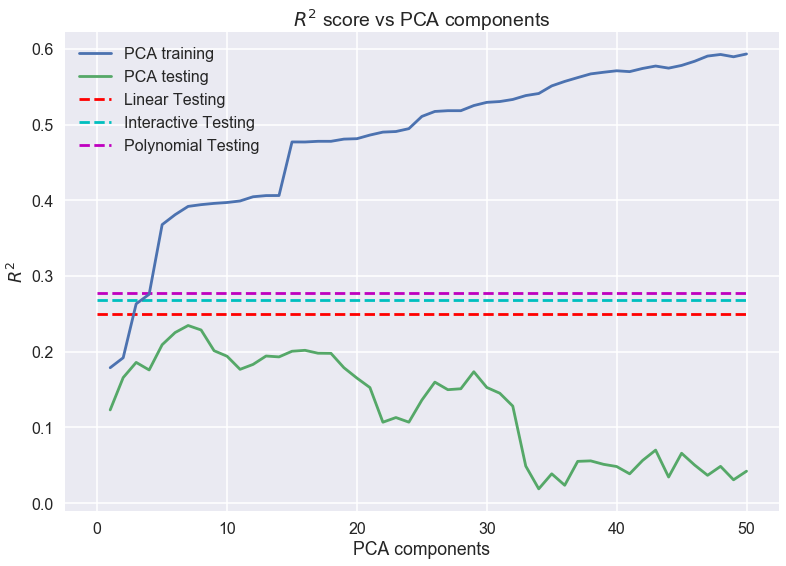

In [131]:
sns.set_context('poster')
plt.plot(np.array(range(1, max_PCA_comp)), np.array(R2_train_PCA), label='PCA training')
plt.plot(np.array(range(1, max_PCA_comp)), np.array(R2_test_PCA), label='PCA testing')
plt.hlines(y=r2_MLR, xmin=0, xmax=max_PCA_comp-1, color='r', linestyles='dashed', label='Linear Testing')
plt.hlines(y=r2_MLR_inter, xmin=0, xmax=max_PCA_comp-1, color='c', linestyles='dashed', label='Interactive Testing')
plt.hlines(y=r2_MLR_poly, xmin=0, xmax=max_PCA_comp-1, color='m', linestyles='dashed', label='Polynomial Testing')
plt.legend(loc='best')
plt.xlabel('PCA components')
plt.ylabel('$R^2$')
plt.title('$R^2$ score vs PCA components')
plt.show()

The plot above shows the $R^2$ score for the PCA with number of components from 1 to 50. As expected, the $R^2$ score in the training set increases as the component number increase. However, surprisingly, the $R^2$ score of the PCA testing set never reach the level of the Interactive or polynomial testing for n < 50, and reachs its maximum value of 0.235 at n = 6

## Part (i): Beyond Squared Error

We have seen in class that the multiple linear regression method optimizes the Mean Squared Error (MSE) on the training set. Consider the following alternate evaluation metric, referred to as the Root Mean Squared Logarthmic Error (RMSLE):

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (log(y_i+1) - log(\hat{y}_i+1))^2}.
$$

The *lower* the RMSLE the *better* is the performance of a model. The RMSLE penalizes errors on smaller responses more heavily than errors on larger responses. For example, the RMSLE penalizes a prediction of $\hat{y} = 15$ for a true response of $y=10$ more heavily than a prediction of $\hat{y} = 105$ for a true response of $100$, though the difference in predicted and true responses are the same in both cases. 

This is a natural evaluation metric for bike share demand prediction, as in this application, it is more important that the prediction model is accurate on days where the demand is low (so that the few customers who arrive are served satisfactorily), compared to days on which the demand is high (when it is less damaging to lose out on some customers).

The following code computes the RMSLE for you:

In [136]:
#--------  rmsle
# A function for evaluating Root Mean Squared Logarithmic Error (RMSLE)
# of the linear regression model on a data set
# Input: 
#      y_test (n x 1 array of response variable vals in testing data)
#      y_pred (n x 1 array of response variable vals in testing data)
# Return: 
#      RMSLE (float) 

def rmsle(y, y_pred):     
    # Evaluate sqaured error, against target labels
    # rmsle = \sqrt(1/n \sum_i (log (y[i]+1) - log (y_pred[i]+1))^2)
    rmsle_ = np.sqrt(np.mean(np.square(np.log(y+1) - np.log(y_pred+1))))
    
    return rmsle_

Use the above code to compute the training and test RMSLE for the polynomial regression model you fit in Part (g). 

You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model? 

**Note:** We do not require you to implement a new regression solver for RMSLE. Instead, we ask you to think about ways to use existing built-in functions to fit a model that performs well on RMSLE. Your regression model may use the same polynomial terms used in Part (g).

In [137]:
rmsle_train_poly = rmsle(Y_train, MLR_result_poly.predict(sm.add_constant(X_train_poly)))
rmsle_test_poly = rmsle(Y_test, MLR_result_poly.predict(sm.add_constant(X_test_poly)))

print("RMSLE Training: %.5f\nRMSLE Testing: %.5f" % (rmsle_train_poly, rmsle_test_poly))

RMSLE Training: 0.31064
RMSLE Testing: 0.52427


D:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


To impletment the RMSLE cost function with existing built-in function, we can use the ordinary linear regression model with a new response:

$Y_{new} = ln(Y + 1)$

Then the linear regression cost function on $Y_{new}$ automatically become the RMSLE on $Y$

In [138]:
# Use OLS to fit log(y+1) with X
Y_train_log = np.log(Y_train + 1)
Y_test_log = np.log(Y_test + 1)

MLR_result_log = OLS(Y_train_log, sm.add_constant(X_train_poly)).fit()

Y_train_log_pred = np.exp(MLR_result_log.predict(sm.add_constant(X_train_poly))) - 1
Y_test_log_pred = np.exp(MLR_result_log.predict(sm.add_constant(X_test_poly))) - 1

rmsle_train_poly = rmsle(Y_train, Y_train_log_pred)
rmsle_test_poly = rmsle(Y_test, Y_test_log_pred)

print("RMSLE Training: %.5f\nRMSLE Testing: %.5f" % (rmsle_train_poly, rmsle_test_poly))

RMSLE Training: 0.29117
RMSLE Testing: 0.52355


In [139]:
MLR_result_log.pvalues[MLR_result_log.pvalues < 0.05]

const         1.025111e-180
workingday     1.266310e-03
humidity       2.374314e-05
windspeed      1.067498e-03
season_1       3.455829e-05
month_8        3.387338e-02
weather_1     8.926599e-136
weather_2     1.869153e-145
weather_3      1.548309e-43
dtype: float64

Comparing the RMSLE score on the ordinary linear regression and the "logarithmic" regression, the latter has a lower RMSLE score (0.02 difference) on the training set, while testing set is very similar (0.0007 difference).

## Part (j): Dealing with Erroneous Labels

Due to occasional system crashes, some of the bike counts reported in the data set have been recorded manually. These counts are not very unreliable and are prone to errors. It is known that roughly 5% of the labels in the training set are erroneous (i.e. can be arbitrarily different from the true counts), while all the labels in the test set were confirmed to be accurate. Unfortunately, the identities of the erroneous records in the training set are not available. Can this information about presence of 5% errors in the training set labels (without details about the specific identities of the erroneous rows) be used to improve the performance of the model in Part (g)? Note that we are interested in improving the $R^2$ performance of the model on the test set (not the training $R^2$ score). 

As a final task, we require you to come up with a strategy to fit a regression model, taking into account the errors in the training set labels. Explain the intuition behind your approach (we do not expect a detailed mathematical justification). Use your approach to fit a regression model on the training set, and compare its test $R^2$ with the model in Part (g).

**Note:** Again, we do not require you to implement a new regression solver for handling erroneous labels. It is sufficient that you to come up with an approach that uses existing built-in functions. Your regression model may use the same polynomial terms used in Part (g).

Thoughts:

In linear regression modeling, we assume the error from the predictive value and the true value has normal distribution with 0 mean and a non-zero STD. If we assume this model is correct here, then the further a error is from 0, the less likely this data point belongs to the dataset (and thus more likely to be the erroneous term/outlier). However, not all erroneuous terms are outliers. Hence, we can first find the 5% outliers datapoints. Take the outliers out one by one and fit a regression model using cross-validation in every step and store their scores. The model (with removal of certain outliers) with the best scores should be the one best decribe the data.

In [164]:
from sklearn.model_selection import KFold

In [202]:
Y_diff = Y_train - MLR_result_poly.predict(sm.add_constant(X_train_poly))

In [203]:
count_min = len(X_train_poly)
s_min = 0
for s in np.arange(1, 3, 0.1):
    count = np.abs(np.sum(np.abs(Y_diff) > s*Y_diff.std()) - len(X_train_poly) * 0.05)
    if count < count_min:
        s_min = s
        count_min = count
s_min

1.7000000000000006

In [204]:
ind_outlier = list(X_train_poly[np.abs(Y_diff) > s_min*Y_diff.std()].index)

In [205]:
error_indexes = [([], 0)]
# Use forward selection
for k in range(1, len(ind_outlier)+1):
    best_k_minus_1 = error_indexes[-1][0]
    new_index = list(set(ind_outlier) - set(best_k_minus_1))
    score = []
    
    r2_k = []
    for ind in new_index:
        k_ind = best_k_minus_1 + [ind]
        
        k_X_train = X_train_poly.drop(k_ind)
        
        r2_valid = []
        # Cross-Validation
        for train_ind, valid_ind in KFold(10, shuffle=True).split(k_X_train):
            
            k_X_train_cv = sm.add_constant(k_X_train.iloc[train_ind, :])
            k_X_valid_cv = sm.add_constant(k_X_train.iloc[valid_ind, :])
            
            Y_train_cv = Y_train.drop(k_ind).iloc[train_ind]
            k_MLR_result = OLS(Y_train_cv, k_X_train_cv).fit()
            Y_valid_pred = k_MLR_result.predict(k_X_valid_cv)
            
            Y_valid_cv = Y_train.drop(k_ind).iloc[valid_ind]
            r2_valid.append(r2_score(Y_valid_cv, Y_valid_pred))
            
        r2_k.append(np.mean(np.array(r2_valid)))
    
    best_k = best_k_minus_1 + [new_index[np.argmax(r2_k)]]
    error_indexes.append((best_k, np.max(r2_k)))

In [206]:
error_indexes

[([], 0),
 ([267], 0.5198877460475807),
 ([267, 29], 0.53219637269830733),
 ([267, 29, 224], 0.55037525738199311),
 ([267, 29, 224, 284], 0.54008913948333892),
 ([267, 29, 224, 284, 305], 0.54678852869444383),
 ([267, 29, 224, 284, 305, 251], 0.54542956930149755),
 ([267, 29, 224, 284, 305, 251, 172], 0.56032590783333891),
 ([267, 29, 224, 284, 305, 251, 172, 204], 0.56008471518446279),
 ([267, 29, 224, 284, 305, 251, 172, 204, 287], 0.56822974322239084),
 ([267, 29, 224, 284, 305, 251, 172, 204, 287, 154], 0.58952217825381714),
 ([267, 29, 224, 284, 305, 251, 172, 204, 287, 154, 249], 0.58572130011010648),
 ([267, 29, 224, 284, 305, 251, 172, 204, 287, 154, 249, 60],
  0.56294222967630381),
 ([267, 29, 224, 284, 305, 251, 172, 204, 287, 154, 249, 60, 145],
  0.5921042926502158),
 ([267, 29, 224, 284, 305, 251, 172, 204, 287, 154, 249, 60, 145, 135],
  0.57334609127790304),
 ([267, 29, 224, 284, 305, 251, 172, 204, 287, 154, 249, 60, 145, 135, 83],
  0.56542235734899082),
 ([267, 29, 2

In [207]:
best_indexes_forward = sorted(error_indexes, key=lambda i: i[1])[-1]
best_indexes_forward

([267, 29, 224, 284, 305, 251, 172, 204, 287, 154, 249, 60, 145],
 0.5921042926502158)

In [208]:
X_train_filter = X_train_poly.drop(best_indexes_forward[0])
Y_train_filter = Y_train.drop(best_indexes_forward[0])

MLR_result_filter = OLS(Y_train_filter, sm.add_constant(X_train_filter)).fit()

r2_train_filter = r2_score(Y_train_filter, MLR_result_filter.predict(sm.add_constant(X_train_filter)))
r2_test_filter = r2_score(Y_test, MLR_result_filter.predict(sm.add_constant(X_test_poly)))

print("Training R^2: %.5f\nTesting R^2: %.5f" % (r2_train_filter, r2_test_filter))

Training R^2: 0.71103
Testing R^2: 0.26839


In [209]:
print('R^2 score before removal of errneous terms: %.5f\nR^2 score after removal of errneous terms: %.5f' % 
     (r2_MLR_poly, r2_test_filter))

R^2 score before removal of errneous terms: 0.27724
R^2 score after removal of errneous terms: 0.26839


# APCOMP209a - Homework Question



##  Question 1: Student's t MLE

Use Maximum Likelihood Estimation to generate a linear regression model on the data provided in ``beerdata.csv`` considering two statistical models for noise: a) iid Normal and b) iid Student's t-distribution with $\nu=5$ and scale factor σ=0.5.  

Compare the two models performances and comment why it is perhaps appropriate to use the Student's t-distribution instead of the Normal? 





HINTS:
1. Use the probability density function for the Student's t distribution  with location μ and scale factor σ.
2. If the MLE regressions coefficients can not be derived analytically consider numerical methods.
3. You can use sklearn or statsmodel for the Normal case 




In [236]:
beerdata = pd.read_csv('data/beerdata.csv', index_col=0)
x = beerdata['x'].values.reshape(-1, 1)
y = beerdata['y'].values.reshape(-1, 1)

#### Normal Model ####

In [237]:
from sklearn.linear_model import LinearRegression

In [238]:
normal_model = LinearRegression()
normal_model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### t-distribution model ####

In [241]:
import pymc3 as pm

with pm.Model() as model:
    
    # Priors for unknown model parameters
    intercept = pm.Normal('intercept', mu=0, sd=10)
    slope = pm.Normal('slope', mu=0, sd=10)
    
    # Likelihood (sampling distribution) of observations
    y_pred = pm.StudentT('y_pred', nu=5, mu=intercept+slope*x, sd=0.5, observed=y)
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -35.403: 100%|██████████| 200000/200000 [00:10<00:00, 19783.64it/s]
Finished [100%]: Average ELBO = -35.439
100%|██████████| 1000/1000 [00:01<00:00, 567.87it/s]


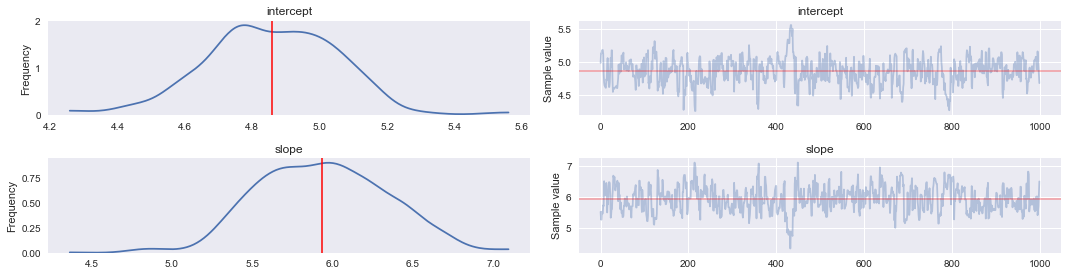

In [245]:
with model:
    trace_studentt = pm.sample(1000)

_ = pm.traceplot(trace_studentt[-1000:], figsize=(15,len(trace_studentt.varnames)*2),
                lines={k: v['mean'] for k, v in pm.df_summary(trace_studentt[-1000:]).iterrows()})

In [248]:
intercept = trace_studentt["intercept"].mean()
slope = trace_studentt["slope"].mean()
y_pred_t = x*slope+intercept

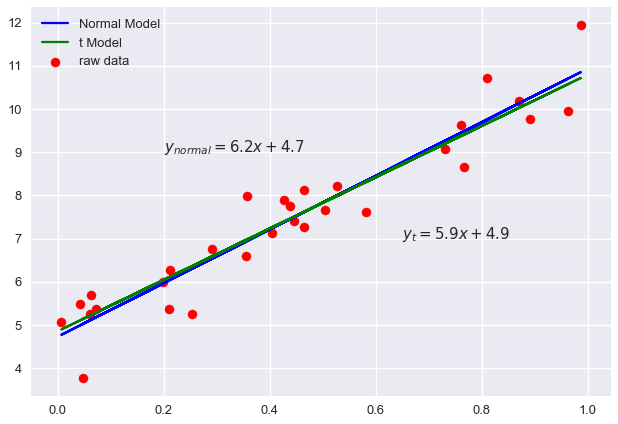

In [251]:
sns.set_context('talk')
plt.scatter(x, y, c='r', label='raw data')
plt.plot(x, normal_model.predict(x), c='b', label='Normal Model')
plt.plot(x, y_pred_t, c='g', label='t Model')
plt.text(x=0.2, y=9, fontsize=15, 
         s='$y_{normal} = %.1fx + %.1f$' % (normal_model.coef_[0], normal_model.intercept_[0]))
plt.text(x=0.65, y=7, fontsize=15, 
         s='$y_{t} = %.1fx + %.1f$' % (slope, intercept))
plt.legend(loc='best')
plt.show()

In [253]:
r2_normal = r2_score(y, normal_model.predict(x))
r2_t = r2_score(y, y_pred_t)
print("Normal Model R^2: %.5f\nt model R^2: %.5f" % (r2_normal, r2_t))

Normal Model R^2: 0.90792
t model R^2: 0.90624


t-distribution is more appropriate when the sample size is small and the true population STD is unknown. The sample STD is weighted less in fitting the linear regression model, thus the outliers in the sample are less significant.

## Question 2 (continued from HW2) 

Read sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, the model leverages the concept that "patterns from a single-object class lie on a linear subspace."   It also makes use of the idea of linear regression as a problem about projections.  In this case, given a vector $y$, the goal is to find the subspace induced by $\mathrm{Col} \, \mathbf X$ that produced the 'closest' projection vector $\widehat y$ to the original $y$.  

### Question 2a

As discussed in the paper, our face dataset contains cleaned images of faces belonging to different people. Assuming that patterns (faces) from one class (person) are elements of the same subspace, let's try to classify an unknown face using the method presented in the paper.  For each class $i$, we need to:

1. construct the $\mathbf H_i$ hat matrix from known faces, being careful to follow the column concatenation step described in the paper to convert an image into its vector representation;
2. calculate the predicted $\widehat y_i$, the closest vector in $\mathrm{Col} \, \mathbf X_i$ to $y$; and
3. calculate the magnitude of the difference vector between $y$ and $\widehat y_i$.

You should then be able to make a classification decision.

**Notes:**
- Use the provided code to download and re-sample the dataset.
- Follow the normalisation step in the paper to ensure the "maximum pixel value is 1".
- Your classifier should have approximately an 80% accuracy.
- Use the image plotting library of matplotlib to display one (or two) correctly classified faces and the known faces.
- Use the image plotting library of matplotlib to display one (or two) incorrectly classified faces and the known faces.
    
### Question 2b - Significant Faces
Select an example of a correctly classified face. Use statsmodels to investigate the most predictive columns (faces) that the model used in this regression:

(i) Which columns (i.e. faces) make the highest contribution to the projection?

(ii) Which columns (i.e. faces) are the least useful in making this projection?

Plot the correctly assigned face, and the two faces from the questions (i) and (ii). What do you notice about these faces?

In [254]:
from io import BytesIO
from zipfile import ZipFile
import urllib
import os

# Note that you may need to run the following command to install Python Image Library (PIL)
#pip install Pillow
from PIL import Image
import numpy as np
from sklearn.cross_validation import train_test_split

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

D:\Anaconda3\envs\py36\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [255]:
# starter functions provided to students
def rgb2gray(rgb):
    '''
    function to convert RGB image to gray scale
    accepts 3D numpy array and returns 2D array with same dimensions
    as the first two dimensions of input
    '''
    
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def fetch_and_read_data(shape=(50,30)):
    
    '''
    Function to download image data, store in a local folder (note this is 18.4mb), only download the data when
    the local folder is not present, read in the images, downsample them to the specified shape (default = (50x30) (rows x cols))
    and finally split them into a four tuple return object.
    
    Returns:
        - 1) training image data (i.e. images that should form the predictor matrix in your solution)
        - 2) training image data labels (i.e. labels from 1 to 50 that identify which face (1) belongs to)
        - 3) testing image data (i.e. data that you should use to try and classify - note this forms the predictor variable in your regression)
        - 4) testing image data labels (i.e. the labels for (3) - this is to allow you to evaluate your model)
    
    ___________________
    Aside:
    If you want to change the sampling dimensions of your data, pass the shape = (x,y) argument to the method where
    y is the number of columns and x is the number of rows in the image.
    '''
    
    if not os.path.exists('./cropped_faces'):
        url = urllib.request.urlopen("http://www.anefian.com/research/GTdb_crop.zip")
        
        zipfile = ZipFile(BytesIO(url.read()))
        zipfile.extractall()
     
    data = []
    labels = []
    
    files = os.listdir('cropped_faces')
    for f in files:
        if '.jpg' in f:
            image = Image.open('cropped_faces/' + f)
            image = image.resize((shape[1], shape[0]))
            data.append(rgb2gray(np.asarray(image)))
            labels.append(int(f.split('_')[0][1:]) - 1)
            
    data = np.array(data)
    
    trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels)
    return np.array(trainX), np.array(testX), np.array(trainY), np.array(testY)

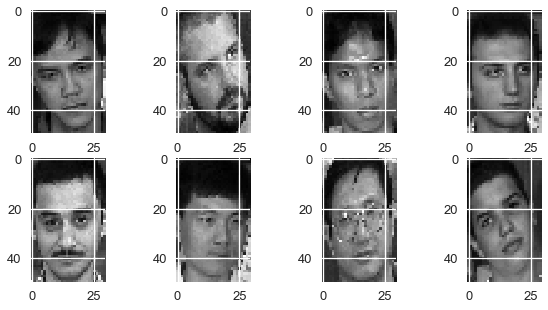

In [406]:
# starter code for the students
train_dataset, test_dataset, train_labels, test_labels = fetch_and_read_data()

# code to plot some of the images
fig, axes = plt.subplots(2,4,figsize=(10,5))
axes = axes.flatten()
[axes[i].imshow(train_dataset[i], cmap='gray') for i in range(len(axes))]
plt.show()

#### 2a ####

In [407]:
def image_to_norm_col(image):
    return image.T.reshape(-1)/image.max()

In [408]:
def get_H(X):
    XT = X.transpose()
    return np.dot(np.dot(X, np.linalg.inv(np.dot(XT, X))), XT)

In [409]:
class_X_dict = dict()

# Get the total number of classes (people)
# Create the column vector of every image in the same class and store them
# Repeat this process for all different classes
class_set = set(train_labels)
for c in class_set:
    image_class = train_dataset[train_labels==c]
    
    image_vector_len = image_class[0].shape[0] * image_class[0].shape[1]
    class_size = image_class.shape[0]
    class_X = np.empty((image_vector_len, class_size))
    
    for i, image in enumerate(image_class):
        class_X[:, i] = image_to_norm_col(image)
    
    class_X_dict[c] = class_X

In [412]:
pred_test_labels = []
pred_test_labels_H = []

MLR_model = LinearRegression()

for image in test_dataset:
    test_vector = image_to_norm_col(image)
    distances = np.zeros(len(class_X_dict))
    distances_H = np.zeros(len(class_X_dict))
    
    for class_label, class_X in class_X_dict.items():
        MLR_model.fit(class_X, test_vector)
        H = get_H(class_X)
        distances[class_label] = np.linalg.norm(MLR_model.predict(class_X)-test_vector)
        distances_H[class_label] = np.linalg.norm(np.dot(H, test_vector)-test_vector)
    
    pred_test_labels.append(np.argmin(distances))
    pred_test_labels_H.append(np.argmin(distances_H))
    
pred_test_labels = np.array(pred_test_labels)
pred_test_labels_H = np.array(pred_test_labels_H)

In [413]:
print('Accuracy: %.2f%%' % ((pred_test_labels == test_labels).mean()*100))

Accuracy: 80.67%


In [415]:
print('Accuracy (hat matrix): %.2f%%' % ((pred_test_labels_H == test_labels).mean()*100))

Accuracy (hat matrix): 79.33%


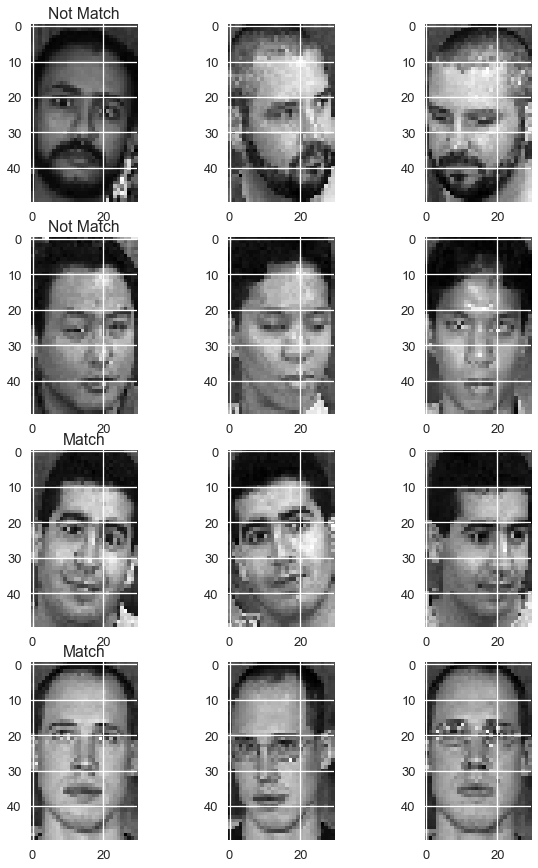

In [327]:
fig, ax = plt.subplots(4,3,figsize=(10,15))
ax = ax.flatten()

match_labels = pred_test_labels == test_labels
match_labels_not = pred_test_labels != test_labels

ax[0].imshow(test_dataset[match_labels_not][0], cmap='gray')
ax[0].set_title('Not Match')
ax[1].imshow(train_dataset[train_labels==pred_test_labels[match_labels_not][0]][0], cmap='gray')
ax[2].imshow(train_dataset[train_labels==pred_test_labels[match_labels_not][0]][-1], cmap='gray')

ax[3].imshow(test_dataset[match_labels_not][-1], cmap='gray')
ax[3].set_title('Not Match')
ax[4].imshow(train_dataset[train_labels==pred_test_labels[match_labels_not][-1]][0], cmap='gray')
ax[5].imshow(train_dataset[train_labels==pred_test_labels[match_labels_not][-1]][-1], cmap='gray')

ax[6].imshow(test_dataset[match_labels][0], cmap='gray')
ax[6].set_title('Match')
ax[7].imshow(train_dataset[train_labels==pred_test_labels[match_labels][0]][0], cmap='gray')
ax[8].imshow(train_dataset[train_labels==pred_test_labels[match_labels][0]][-1], cmap='gray')

ax[9].imshow(test_dataset[match_labels][-1], cmap='gray')
ax[9].set_title('Match')
ax[10].imshow(train_dataset[train_labels==pred_test_labels[match_labels][-1]][0], cmap='gray')
ax[11].imshow(train_dataset[train_labels==pred_test_labels[match_labels][-1]][-1], cmap='gray')

plt.show()

#### 2b ####

In [353]:
match_image = test_dataset[match_labels][-1]
match_class = test_labels[match_labels][-1]

In [364]:
match_y = image_to_norm_col(match_image)
match_X = class_X_dict[match_class]

MLR_model = LinearRegression()
MLR_model.fit(match_X, match_y)

coefs_df = pd.Series(np.abs(MLR_model.coef_))

In [370]:
coef_ind_sort = np.array(coefs_df.sort_values().index)
max_3_ind = coef_ind_sort[-3:]
min_3_ind = coef_ind_sort[:3]

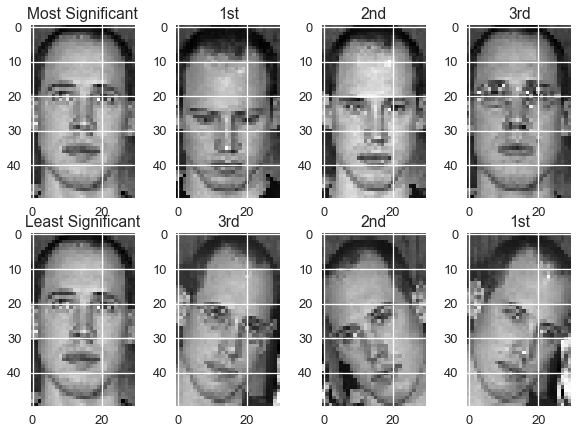

In [376]:
fig, ax = plt.subplots(2,4,figsize=(10,7))
ax = ax.flatten()

ax[0].imshow(match_image, cmap='gray')
ax[0].set_title('Most Significant')
ax[1].imshow(train_dataset[train_labels==match_class][max_3_ind[0]], cmap='gray')
ax[1].set_title('1st')
ax[2].imshow(train_dataset[train_labels==match_class][max_3_ind[1]], cmap='gray')
ax[2].set_title('2nd')
ax[3].imshow(train_dataset[train_labels==match_class][max_3_ind[2]], cmap='gray')
ax[3].set_title('3rd')

ax[4].imshow(match_image, cmap='gray')
ax[4].set_title('Least Significant')
ax[5].imshow(train_dataset[train_labels==match_class][min_3_ind[0]], cmap='gray')
ax[5].set_title('3rd')
ax[6].imshow(train_dataset[train_labels==match_class][min_3_ind[1]], cmap='gray')
ax[6].set_title('2nd')
ax[7].imshow(train_dataset[train_labels==match_class][min_3_ind[2]], cmap='gray')
ax[7].set_title('1st')

plt.show()

The most significant contribution comes from the images whose head shot has similar angle with the test one.